In [16]:
import os
import cv2
import rowan
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

from models.resnet import ResNetVAE
from utils_.plotting import plot_waypoints_and_initial_image
from utils_.waypoint_extraction import pickplace_task_waypoints
from utils_.utils import from_sim_get_poses_n_gripper, waypoints_from_bridge_build

torch.cuda.empty_cache()

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Name: {torch.cuda.get_device_name(device)}" if device.type == "cuda" else "Using cpu")
DATA_PATH = "./datasets/bridge"
IMAGE_RESIZE = 128
LATENT_DIM = 64
DATAPOINT_COUNT = 200
AE_PATH = "./logs/models/VAE_2024-10-25_16:30/pth/epoch_400.pth"
L2W_PATH = "./logs/models/mlp_2024-10-21_16:47/pth/epoch_2000.pth"
USE_ROTATIONS = True

Device Name: NVIDIA GeForce RTX 3090


In [18]:
# Create the input data: latent representation of initial scene images
im_paths = [f"{DATA_PATH}/img/image{i}.png" for i in range(DATAPOINT_COUNT)]
X = []
for i, im_path in tqdm(enumerate(im_paths)):
    image = cv2.imread(im_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMAGE_RESIZE, IMAGE_RESIZE))
    image = image/255.0
    image = np.transpose(image, (2, 0, 1))  # HWC to CHW
    X.append(image)

X = np.array(X)
print(X.shape)

200it [00:00, 445.37it/s]

(200, 3, 128, 128)


In [19]:
# Create output data: waypoint collections from the paths
paths_paths = [f"{DATA_PATH}/paths/path{i}.npy" for i in range(DATAPOINT_COUNT)]

ways = []
for i, ep_path in tqdm(enumerate(paths_paths)):
    pos, quat = waypoints_from_bridge_build(ep_path)
    ep_ways = []
    for j, _ in enumerate(pos):
        rot = rowan.to_matrix(quat[j])[:2].flatten()
        ep_ways.append([*pos[j]])
    ep_ways = np.array(ep_ways).flatten()
    ways.append(ep_ways)
ways = np.array(ways)

y = ways.reshape(ways.shape[0], -1)
del ways
print(y.shape)

200it [00:06, 29.33it/s]


(200, 18)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)
X_val_tensor = torch.tensor(X_test, dtype=torch.float)
y_val_tensor = torch.tensor(y_test, dtype=torch.float)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [21]:
import json
import torch.nn as nn
from datetime import datetime


class MLPdc(nn.Module):
  
    def __init__(self, input_dim: int, output_dim: int, hidden_layers: list[int]=[256, 256, 256]):
        super(MLPdc, self).__init__()
        layers = []
        self.output_dim = output_dim
        last_dim = input_dim + output_dim + 1
        for size in hidden_layers:
            layers.append(nn.Linear(last_dim, size))
            layers.append(nn.ReLU())
            last_dim = size

        layers.append(nn.Linear(last_dim, output_dim))

        self.layers = nn.Sequential(*layers)

        self.model_params = {
            'input_size': input_dim,
        }

        self.path = "."

    def generate_log_data_path(self):
        current_time = datetime.now().strftime("%Y-%m-%d_%H:%M")
        self.path = f"./logs/models/diffuser-mlp_{current_time}"
        if not os.path.exists(f"{self.path}/pth"):
            os.makedirs(f"{self.path}/pth")

    def log_model(self):
        self.generate_log_data_path()
        with open(f'{self.path}/model_params.json', 'w', encoding='utf-8') as f:
            json.dump(self.model_params, f)
    
    def save(self, epoch: int):
        file_name = f"{self.path}/pth/epoch_{epoch}.pth"
        torch.save(self.state_dict(), file_name)

    def forward(self, c, x, t):
        x = torch.concat([x, c, t], axis=-1)
        x = self.layers(x)
        return x
    
    def sample(self, conditioning: np.ndarray, device: str, n_steps: int=100):
        n_samples = conditioning.shape[0]
        x_t = torch.randn((n_samples, self.output_dim)).to(device)
        
        for i in range(n_steps):
            x_t += torch.randn((n_samples, self.output_dim)).to(device) * .001

            # t = torch.zeros((n_samples, 1)).to(device) + i / n_steps
            t = torch.ones((n_samples, 1)).to(device)

            noise_prediction = self(conditioning, x_t, t)
            # noise_prediction /= n_steps - i
            noise_prediction /= n_steps
            x_t -= noise_prediction

        return x_t

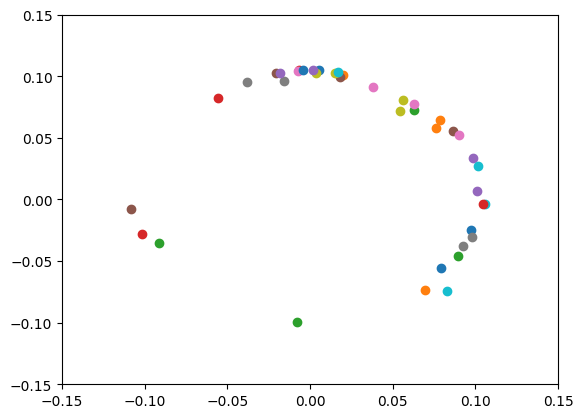

In [22]:
for y in y_test:
    cond_y = y[3:6]
    y2pred = y[9:12] - cond_y
    plt.scatter([y2pred[0]], [y2pred[1]])
plt.xlim((-.15, .15))
plt.ylim((-.15, .15))
plt.show()

In [33]:
def vae_loss(reconstructed, original, mu, log_var, beta):
    recon_loss = F.mse_loss(reconstructed, original, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + beta * kl_div


def train_mlps(mlp_models, encoder_vae):
    lr=1e-3
    n_epochs=2_000
    recontruction_importance = 1e-4  # Does this change anything?

    optimizer = torch.optim.Adam(
        list(mlp_models[0].parameters()) +
        list(mlp_models[1].parameters()) +
        list(mlp_models[2].parameters()) +
        list(mlp_models[3].parameters()) +
        list(mlp_models[4].parameters()) +
        list(mlp_models[5].parameters()) +
        list(encoder_vae.parameters()),
        lr=lr
    )

    for i in range(len(mlp_models)):
        mlp_models[i].to(device)
    encoder_vae.to(device)
    train_losses_ways = []
    train_losses_imgs = []
    loss_fn = nn.MSELoss()


    encoder_vae.train()
    for i in range(len(mlp_models)):
        mlp_models[i].train()

    for epoch in range(n_epochs):
        
        train_loss_waypoints = 0
        train_loss_reconstruction = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()

            # Image reconstruction
            latent_image, logvar = encoder_vae.encoder(X)
            z = encoder_vae.reparameterize(latent_image, logvar)
            reconstructed = encoder_vae.decoder(z)

            loss_waypoints = 0
            for pred_waypoint_idx in range(len(mlp_models)):
                cond_y = y[:, :pred_waypoint_idx*3]
                y2pred = y[:, pred_waypoint_idx*3:pred_waypoint_idx*3+3]

                # Waypoint prediction
                with torch.no_grad():
                    t = torch.rand(size=(y.shape[0], 1), device=device)
                    noise = torch.randn(y.shape[0], 3, device=device)
                    model_in = y2pred * t + noise * ( torch.ones(size=(y.shape[0], 1), device=device) - t )
                
                cond = torch.concat([latent_image, cond_y], axis=-1)
                out = mlp_models[pred_waypoint_idx](cond, model_in, t)

                loss_waypoints += loss_fn(noise, out)

            # Compute losses
            loss_reconstruction = recontruction_importance * vae_loss(reconstructed, X, latent_image, logvar, beta=.1)
            loss = loss_reconstruction + loss_waypoints

            train_loss_waypoints += loss_waypoints.item()
            train_loss_reconstruction += loss_reconstruction.item()

            loss.backward()
            optimizer.step()

        train_loss_waypoints /= len(train_loader)
        train_loss_reconstruction /= len(train_loader)
        train_losses_ways.append(train_loss_waypoints)
        train_losses_imgs.append(train_loss_reconstruction)

        # Print losses for this epoch
        if (epoch+1) % 1 == 0:
            print(f"Epoch {epoch + 1},\t Train Loss waypoints: {train_loss_waypoints:.6f}, Train Loss images: {train_loss_reconstruction:.6f}\t")

In [34]:
encoder = ResNetVAE(latent_dim=LATENT_DIM, in_channels=3).to(device=device)
mlp_models = []
for i in range(len(y_test[0])//3):
    mlp_models.append(MLPdc(LATENT_DIM+i*3, 3, hidden_layers=[1024, 256]).to(device))
print(len(mlp_models))

6


In [35]:
train_mlps(mlp_models, encoder)

Epoch 1,	 Train Loss waypoints: 6.989223, Train Loss images: 12.614025	
Epoch 2,	 Train Loss waypoints: 5.967954, Train Loss images: 4.061678	
Epoch 3,	 Train Loss waypoints: 5.731741, Train Loss images: 1.777803	
Epoch 4,	 Train Loss waypoints: 5.517047, Train Loss images: 1.229592	
Epoch 5,	 Train Loss waypoints: 5.100609, Train Loss images: 1.051977	
Epoch 6,	 Train Loss waypoints: 4.580226, Train Loss images: 0.925316	
Epoch 7,	 Train Loss waypoints: 4.019723, Train Loss images: 0.836583	
Epoch 8,	 Train Loss waypoints: 3.204246, Train Loss images: 0.799127	
Epoch 9,	 Train Loss waypoints: 3.035445, Train Loss images: 0.735067	
Epoch 10,	 Train Loss waypoints: 2.470144, Train Loss images: 0.703336	
Epoch 11,	 Train Loss waypoints: 2.185051, Train Loss images: 0.714261	
Epoch 12,	 Train Loss waypoints: 1.823105, Train Loss images: 0.689498	
Epoch 13,	 Train Loss waypoints: 1.774496, Train Loss images: 0.643906	
Epoch 14,	 Train Loss waypoints: 1.597740, Train Loss images: 0.614058	


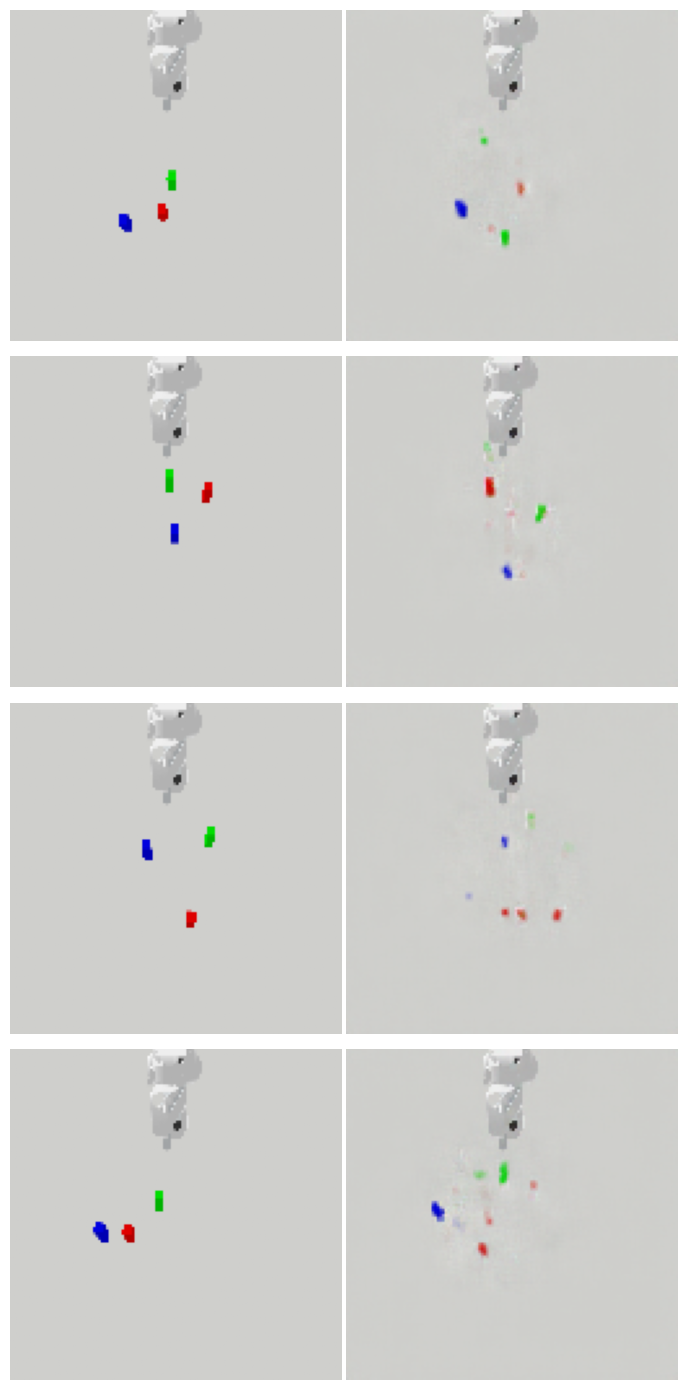

In [36]:
example_count = 4
rand_images = np.array([val_dataset[np.random.randint(0, len(val_dataset))][0] for _ in range(example_count)])
pred_images = encoder.forward_clean(torch.Tensor(rand_images).to(device))

fig, axes = plt.subplots(example_count, 2, figsize=(7, 14))

for i in range(example_count):
    image = np.transpose(rand_images[i], (1, 2, 0))
    axes[i, 0].imshow(image)
    axes[i, 1].imshow(pred_images[i])

    axes[i, 0].axis('off')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [37]:
for i in range(len(mlp_models)):
    print(f"+-------------------- RESULTS FOR FM {i} ----------------------+")
    for j in range(2):
        if j:
            cond_y = torch.Tensor(y_test[:, :i*3]).to(device)
            y2pred = torch.Tensor(y_test[:, i*3:i*3+3]).to(device)
            
            latent_images, _ = encoder.encode(torch.Tensor(X_test).to(device))
            cond = torch.concat([latent_images, cond_y], axis=-1)
            y_pred = mlp_models[i].sample(cond, device)
            errors = (y2pred - y_pred).cpu().detach().numpy()
        else:
            cond_y = torch.Tensor(y_train[:, :i*3]).to(device)
            y2pred = torch.Tensor(y_train[:, i*3:i*3+3]).to(device)
            
            latent_images, _ = encoder.encode(torch.Tensor(X_train).to(device))
            cond = torch.concat([latent_images, cond_y], axis=-1)
            y_pred = mlp_models[i].sample(cond, device)
            errors = (y2pred - y_pred).cpu().detach().numpy()
        
        errors = errors[:, :2]
        errors = [np.linalg.norm(e) for e in errors]
        mean_error = sum(errors)/len(errors)
        devs = [abs(e-mean_error) for e in errors]
        dev_error = sum(devs)/len(devs)

        max_error = .03
        total_wins = 0
        for e in errors:
            if e < max_error:
                total_wins += 1

        if j:
            print("Test avg. dist. from desired point (m): ", mean_error)
            print("Test avg. dev. from desired point (m): ", dev_error)
            print(f"Success rate: {(total_wins/len(errors)*100):.2f}%")
        else:
            print("Train avg. dist. from desired point (m): ", mean_error)
            print("Train avg. dev. from desired point (m): ", dev_error)
        print("+--------------------------------------------------------------+")

+-------------------- RESULTS FOR FM 0 ----------------------+
Train avg. dist. from desired point (m):  0.023962060470876168
Train avg. dev. from desired point (m):  0.01084220444191487
+--------------------------------------------------------------+
Test avg. dist. from desired point (m):  0.0649322445387952
Test avg. dev. from desired point (m):  0.03486090474470984
Success rate: 22.50%
+--------------------------------------------------------------+
+-------------------- RESULTS FOR FM 1 ----------------------+
Train avg. dist. from desired point (m):  0.0210205169962137
Train avg. dev. from desired point (m):  0.009265700797495809
+--------------------------------------------------------------+
Test avg. dist. from desired point (m):  0.09404193870723247
Test avg. dev. from desired point (m):  0.03898288581520319
Success rate: 12.50%
+--------------------------------------------------------------+
+-------------------- RESULTS FOR FM 2 ----------------------+
Train avg. dist. from

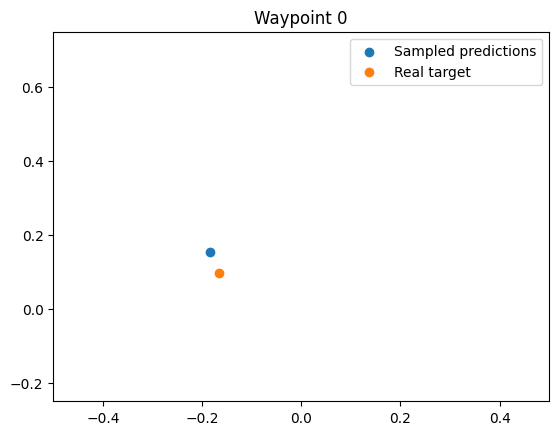

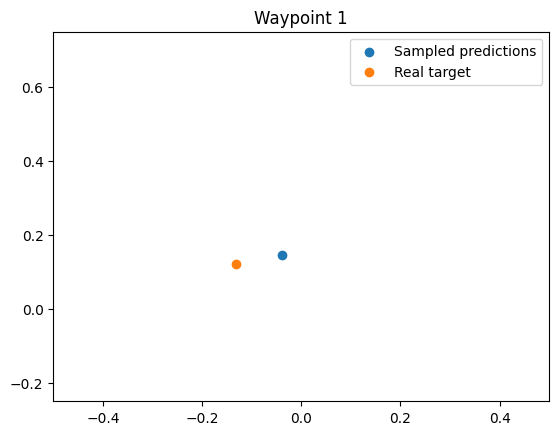

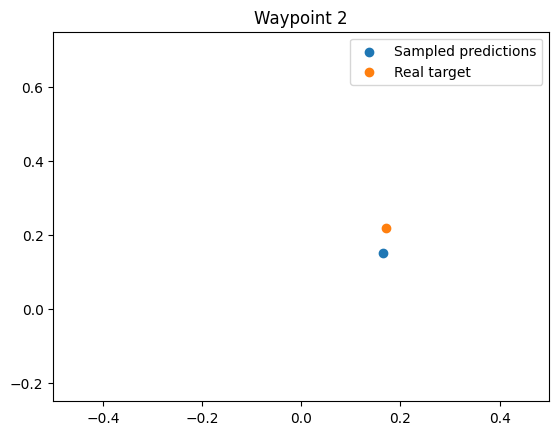

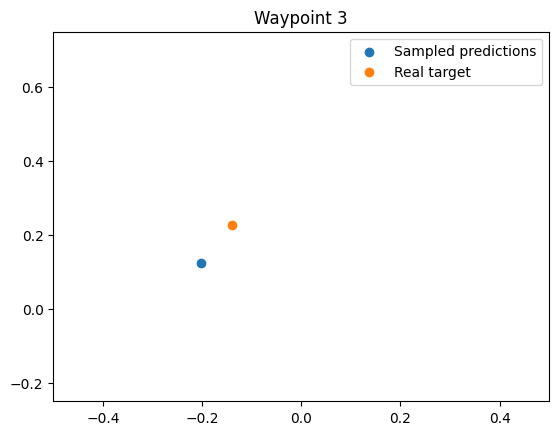

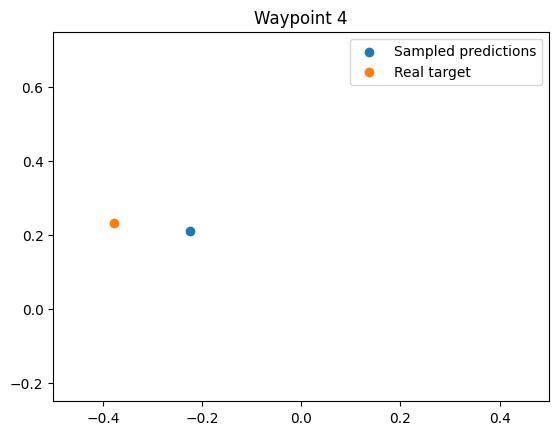

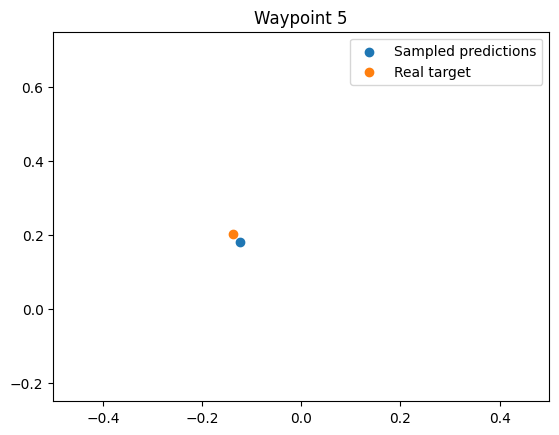

In [38]:
def sample(model, conditioning: np.ndarray, device: str, n_samples: int=50, n_steps: int=50):
    n_samples = conditioning.shape[0]
    x_t = torch.randn((n_samples, model.output_dim)).to(device)
        
    for i in range(n_steps):
        # x_t += torch.randn((n_samples, model.output_dim)).to(device) * .001

        t = torch.zeros((n_samples, 1)).to(device) + i / n_steps
        # t = torch.ones((n_samples, 1)).to(device)

        noise_prediction = model(conditioning, x_t, t)
        # noise_prediction /= n_steps - i
        noise_prediction /= n_steps
        x_t -= noise_prediction

    return x_t

idx = np.random.choice(list(range(len(y_test))))

for i in range(len(mlp_models)):
    cond_y = torch.Tensor([y_test[idx][:i*3]]).to(device)
    y2pred = y_test[idx][i*3:i*3+3]
    
    latent_images, _ = encoder.encode(torch.Tensor([X_test[idx]]).to(device))
    cond = torch.concat([latent_images, cond_y], axis=-1)
    y_pred = sample(mlp_models[i], cond, device, n_samples=100).cpu().detach().numpy()

    plt.scatter(y_pred[:, 0], y_pred[:, 1], label="Sampled predictions")
    plt.scatter([y2pred[0]], [y2pred[1]], label="Real target")
    plt.title(f"Waypoint {i}")
    plt.xlim((-.5, .5))
    plt.ylim((-.25, .75))
    plt.legend()
    plt.show()